## Deciding when to spin up and spin down expensive infrastructure
The following script using networkx to create various graphs of the Artificien website and use them to predict how long it will take each user to send a model, and use these predictions to decide when to spin up/spin down Artificien infrastructure

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing import nx_pydot
from graphviz import Source
import math

### Treating the Artificien Website as a Multi Directed Graph

To start let's consider the Artificien Website to be a Multi Directed Graph. We'll consider node costs to be equal to edge weights of the target. As we're interested in the shortest path for each user, we can transform it into a directed graph by eliminating the higher cost edge for any pair of edges between nodes. Then we'll just use Dijkstra's to find the shortest path between any node and "Send Model"

In [11]:
# pull directed edges from csv
df = pd.read_csv('data/artificien_multigraph.csv')
# instantiate a multi directed graph (can have two directed edges between nodes), load graph from csv
Graphtype = nx.MultiDiGraph()
G = nx.from_pandas_edgelist(df, edge_attr='weight', edge_key="weight", create_using=Graphtype)

In [4]:
# our nodes
list(G.nodes)

['How Artificien Works',
 'Landing',
 'Exit',
 'Marketplace',
 'Profile',
 'My Models',
 'Documentation',
 'Jupyter',
 'Send Model']

In [5]:
# our edges and associated transition probabilities
G.edges

OutMultiEdgeView([('How Artificien Works', 'Landing', 2), ('How Artificien Works', 'Exit', 0), ('Landing', 'How Artificien Works', 4), ('Landing', 'Marketplace', 7), ('Landing', 'Profile', 4), ('Landing', 'My Models', 4), ('Landing', 'Documentation', 15), ('Landing', 'Exit', 0), ('Marketplace', 'Landing', 2), ('Marketplace', 'My Models', 4), ('Marketplace', 'Profile', 4), ('Marketplace', 'Documentation', 15), ('Marketplace', 'Exit', 0), ('Profile', 'Marketplace', 7), ('Profile', 'Landing', 2), ('Profile', 'My Models', 4), ('Profile', 'Documentation', 15), ('Profile', 'Exit', 0), ('My Models', 'Documentation', 15), ('My Models', 'Profile', 4), ('My Models', 'Marketplace', 7), ('My Models', 'Landing', 2), ('My Models', 'Exit', 0), ('My Models', 'Jupyter', 30), ('Documentation', 'Profile', 4), ('Documentation', 'Marketplace', 7), ('Documentation', 'Landing', 2), ('Documentation', 'Exit', 0), ('Documentation', 'My Models', 4), ('Jupyter', 'Exit', 0), ('Jupyter', 'Send Model', 0)])

{('How Artificien Works', 'Landing'): Text(315.5, 414.0, '2'),
 ('How Artificien Works', 'Exit'): Text(335.5, 234.0, '0'),
 ('Landing', 'How Artificien Works'): Text(315.5, 414.0, '4'),
 ('Landing', 'Marketplace'): Text(266.0, 270.0, '7'),
 ('Landing', 'Profile'): Text(347.5, 234.0, '4'),
 ('Landing', 'My Models'): Text(266.0, 306.0, '4'),
 ('Landing', 'Documentation'): Text(315.5, 342.0, '15'),
 ('Landing', 'Exit'): Text(335.5, 198.0, '0'),
 ('Marketplace', 'Landing'): Text(266.0, 270.0, '2'),
 ('Marketplace', 'My Models'): Text(216.5, 198.0, '4'),
 ('Marketplace', 'Profile'): Text(298.0, 126.0, '4'),
 ('Marketplace', 'Documentation'): Text(266.0, 234.0, '15'),
 ('Marketplace', 'Exit'): Text(286.0, 90.0, '0'),
 ('Profile', 'Marketplace'): Text(298.0, 126.0, '7'),
 ('Profile', 'Landing'): Text(347.5, 234.0, '2'),
 ('Profile', 'My Models'): Text(298.0, 162.0, '4'),
 ('Profile', 'Documentation'): Text(347.5, 198.0, '15'),
 ('Profile', 'Exit'): Text(367.5, 54.0, '0'),
 ('My Models', 'Docu

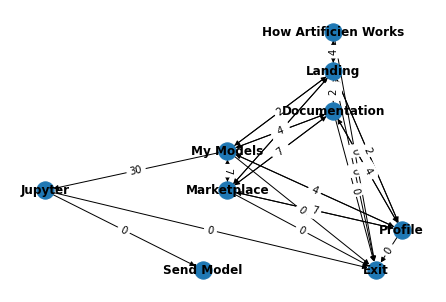

In [6]:
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw(G, with_labels=True, font_weight='bold', pos=pos)
edge_labels = {(n1,n2):d['weight'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)

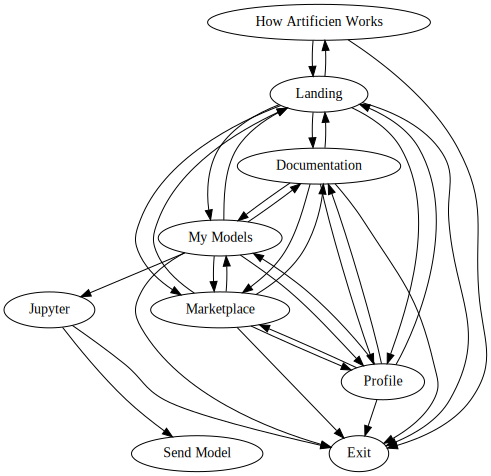

In [7]:
nx_pydot.write_dot(G, 'figures/artificien_multidi.dot')
Source.from_file('figures/artificien_multidi.dot')

In [8]:
# we can find the shortest path from any node using networkx's built in functions.
# On the backend, it's just converting this multi directed graph into a directed graph
# then running Dijkstra's
paths = {}
for node in list(G.nodes):
    if node != "Send Model" and node != "Exit":
        short = nx.shortest_path_length(G,source=node,target='Send Model', weight='weight')
        value = [[p for p in nx.all_shortest_paths(G,source=node,target='Send Model')], short]
        paths[node] = value


In [9]:
paths

{'How Artificien Works': [[['How Artificien Works',
    'Landing',
    'My Models',
    'Jupyter',
    'Send Model']],
  36],
 'Landing': [[['Landing', 'My Models', 'Jupyter', 'Send Model']], 34],
 'Marketplace': [[['Marketplace', 'My Models', 'Jupyter', 'Send Model']], 34],
 'Profile': [[['Profile', 'My Models', 'Jupyter', 'Send Model']], 34],
 'My Models': [[['My Models', 'Jupyter', 'Send Model']], 30],
 'Documentation': [[['Documentation', 'My Models', 'Jupyter', 'Send Model']],
  34],
 'Jupyter': [[['Jupyter', 'Send Model']], 0]}

### Creating a Markov Chain of the Artificien Website

The above solution isn't ideal for one primary reason - it assumes the probability of going from a given node to any other connected node is equal. This is clearly an erroneous assumption - some pages will be significantly less visited than others. We're gonna build a Markov chain here, where our edge weights become the probability of a transition, and our node weights are the amount of time spent on a node, then use this data structure instead. While a markov chain has no concept of memory, and our transitions are purely based on the current state (which isn't ideal because it's improbable I travel to a page I've already visited), we're only concerned about most probable/shortest path to sending a model, so it shouldn't matter so much

In [16]:
# pull directed edges from csv
df = pd.read_csv('data/artificien_multi_markov.csv')
# instantiate a multi directed graph (can have two directed edges between nodes), load graph from csv
Graphtype = nx.MultiDiGraph()
G = nx.from_pandas_edgelist(df, edge_attr='weight', edge_key="weight", create_using=Graphtype)

In [17]:
df

,source,target,weight
0,How Artificien Works,Landing,0.4
1,How Artificien Works,Exit,0.6
2,Landing,How Artificien Works,0.4
3,Landing,Marketplace,0.1
4,Landing,Profile,0.1
5,Landing,My Models,0.1
6,Landing,Documentation,0.1
7,Landing,Exit,0.2
8,Marketplace,Landing,0.1
9,Marketplace,My Models,0.2


In [11]:
# our nodes
list(G.nodes)

['How Artificien Works',
 'Landing',
 'Exit',
 'Marketplace',
 'Profile',
 'My Models',
 'Documentation',
 'Jupyter',
 'Send Model']

In [12]:
# our edges and associated transition probabilities
G.edges

OutMultiEdgeView([('How Artificien Works', 'Landing', 0.4), ('How Artificien Works', 'Exit', 0.6), ('Landing', 'How Artificien Works', 0.4), ('Landing', 'Marketplace', 0.1), ('Landing', 'Profile', 0.1), ('Landing', 'My Models', 0.1), ('Landing', 'Documentation', 0.1), ('Landing', 'Exit', 0.2), ('Marketplace', 'Landing', 0.1), ('Marketplace', 'My Models', 0.2), ('Marketplace', 'Profile', 0.2), ('Marketplace', 'Documentation', 0.1), ('Marketplace', 'Exit', 0.3), ('Profile', 'Marketplace', 0.2), ('Profile', 'Landing', 0.1), ('Profile', 'My Models', 0.3), ('Profile', 'Documentation', 0.2), ('Profile', 'Exit', 0.2), ('My Models', 'Documentation', 0.1), ('My Models', 'Profile', 0.1), ('My Models', 'Marketplace', 0.1), ('My Models', 'Landing', 0.1), ('My Models', 'Exit', 0.1), ('My Models', 'Jupyter', 0.5), ('Documentation', 'Profile', 0.2), ('Documentation', 'Marketplace', 0.2), ('Documentation', 'Landing', 0.1), ('Documentation', 'Exit', 0.1), ('Documentation', 'My Models', 0.4), ('Jupyter'

In [14]:
# now we need to give our graph node costs
nodeData = pd.DataFrame({'node' : G.nodes, 'weight' : [4, 2, 0, 7, 4, 4, 15, 30, 0]})

In [15]:
nodeData

,node,weight
0,How Artificien Works,4
1,Landing,2
2,Exit,0
3,Marketplace,7
4,Profile,4
5,My Models,4
6,Documentation,15
7,Jupyter,30
8,Send Model,0


In [14]:
# our nodes and respective costs
nodeData

,node,weight
0,How Artificien Works,4
1,Landing,2
2,Exit,0
3,Marketplace,7
4,Profile,4
5,My Models,4
6,Documentation,15
7,Jupyter,30
8,Send Model,0


In [15]:
# load node costs into graph data structure
nx.set_node_attributes(G, nodeData.set_index('node').to_dict()['weight'], 'weight')

In [16]:
labels = {n: str(n) + ': ' + str(G.nodes[n]['weight']) for n in G.nodes}
colors = [G.nodes[n]['weight'] for n in G.nodes]

{('How Artificien Works', 'Landing'): Text(92.79, 414.0, '0.4'),
 ('How Artificien Works', 'Exit'): Text(230.79000000000002, 234.0, '0.6'),
 ('Landing', 'How Artificien Works'): Text(92.79, 414.0, '0.4'),
 ('Landing', 'Marketplace'): Text(197.79000000000002, 270.0, '0.1'),
 ('Landing', 'Profile'): Text(226.79000000000002, 234.0, '0.1'),
 ('Landing', 'My Models'): Text(139.79, 306.0, '0.1'),
 ('Landing', 'Documentation'): Text(151.79, 342.0, '0.1'),
 ('Landing', 'Exit'): Text(211.79000000000002, 198.0, '0.2'),
 ('Marketplace', 'Landing'): Text(197.79000000000002, 270.0, '0.1'),
 ('Marketplace', 'My Models'): Text(263.79, 198.0, '0.2'),
 ('Marketplace', 'Profile'): Text(350.79, 126.0, '0.2'),
 ('Marketplace', 'Documentation'): Text(275.79, 234.0, '0.1'),
 ('Marketplace', 'Exit'): Text(335.79, 90.0, '0.3'),
 ('Profile', 'Marketplace'): Text(350.79, 126.0, '0.2'),
 ('Profile', 'Landing'): Text(226.79000000000002, 234.0, '0.1'),
 ('Profile', 'My Models'): Text(292.79, 162.0, '0.3'),
 ('Prof

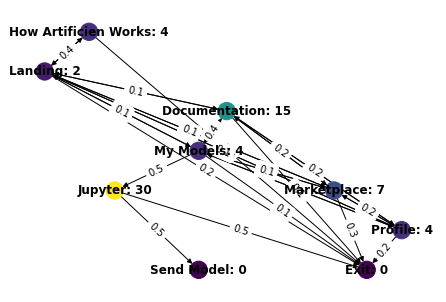

In [17]:
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw(G, with_labels=True, font_weight='bold', labels=labels, node_color=colors, pos=pos)
edge_labels = {(n1,n2):d['weight'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)

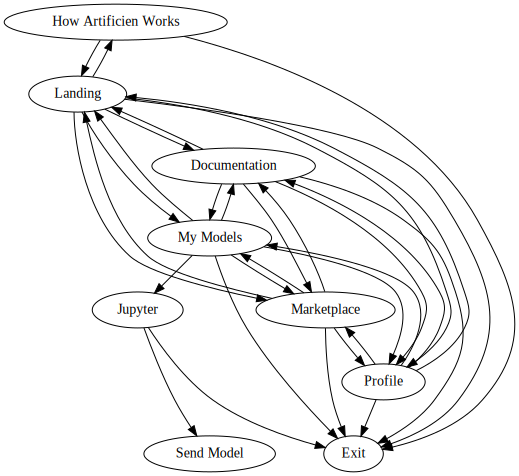

In [18]:
nx_pydot.write_dot(G, 'figures/artificien_markovchain.dot')
Source.from_file('figures/artificien_markovchain.dot')

We want to find the most probable path between for all node pairs (i, "Send Model"), where i is any node != "Exit" or "Send Model" (Our Target and a Dead-end). When thinking about the most probable path, the node weights are irrelevant. All we want is the path that has the highest product of transition probabilities (the most probable). We can take the -log of each of our edge weights (bc log(ab) = log(a) + log(b) and we want all weights to be positive, so we negate them). So let's adjust our weights

In [19]:
# apply natural log and negate
df['weight'] = df['weight'].apply(math.log)
df['weight'] = -1*df['weight']

In [20]:
Graphtype = nx.MultiDiGraph()
M = nx.from_pandas_edgelist(df, edge_attr='weight', edge_key="weight", create_using=Graphtype)

In [21]:
# our edges and associated transition probabilities
list(M.edges)

[('How Artificien Works', 'Landing', 0.916290731874155),
 ('How Artificien Works', 'Exit', 0.5108256237659907),
 ('Landing', 'How Artificien Works', 0.916290731874155),
 ('Landing', 'Marketplace', 2.3025850929940455),
 ('Landing', 'Profile', 2.3025850929940455),
 ('Landing', 'My Models', 2.3025850929940455),
 ('Landing', 'Documentation', 2.3025850929940455),
 ('Landing', 'Exit', 1.6094379124341003),
 ('Marketplace', 'Landing', 2.3025850929940455),
 ('Marketplace', 'My Models', 1.6094379124341003),
 ('Marketplace', 'Profile', 1.6094379124341003),
 ('Marketplace', 'Documentation', 2.3025850929940455),
 ('Marketplace', 'Exit', 1.2039728043259361),
 ('Profile', 'Marketplace', 1.6094379124341003),
 ('Profile', 'Landing', 2.3025850929940455),
 ('Profile', 'My Models', 1.2039728043259361),
 ('Profile', 'Documentation', 1.6094379124341003),
 ('Profile', 'Exit', 1.6094379124341003),
 ('My Models', 'Documentation', 2.3025850929940455),
 ('My Models', 'Profile', 2.3025850929940455),
 ('My Models'

In [22]:
nx.set_node_attributes(M, nodeData.set_index('node').to_dict()['weight'], 'weight')

{('How Artificien Works', 'Landing'): Text(363.5, 414.0, '0.916290731874155'),
 ('How Artificien Works', 'Exit'): Text(381.5, 234.0, '0.5108256237659907'),
 ('Landing', 'How Artificien Works'): Text(363.5, 414.0, '0.916290731874155'),
 ('Landing', 'Marketplace'): Text(281.0, 270.0, '2.3025850929940455'),
 ('Landing', 'Profile'): Text(362.5, 234.0, '2.3025850929940455'),
 ('Landing', 'My Models'): Text(285.0, 306.0, '2.3025850929940455'),
 ('Landing', 'Documentation'): Text(344.5, 342.0, '2.3025850929940455'),
 ('Landing', 'Exit'): Text(362.5, 198.0, '1.6094379124341003'),
 ('Marketplace', 'Landing'): Text(281.0, 270.0, '2.3025850929940455'),
 ('Marketplace', 'My Models'): Text(221.5, 198.0, '1.6094379124341003'),
 ('Marketplace', 'Profile'): Text(299.0, 126.0, '1.6094379124341003'),
 ('Marketplace', 'Documentation'): Text(281.0, 234.0, '2.3025850929940455'),
 ('Marketplace', 'Exit'): Text(299.0, 90.0, '1.2039728043259361'),
 ('Profile', 'Marketplace'): Text(299.0, 126.0, '1.60943791243

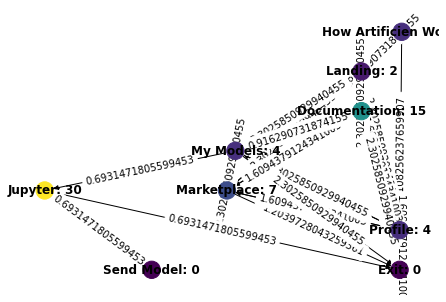

In [23]:
pos = nx.drawing.nx_pydot.graphviz_layout(M, prog='dot')
nx.draw(M, with_labels=True, font_weight='bold', labels=labels, node_color=colors, pos=pos)
edge_labels = {(n1,n2):d['weight'] for n1,n2,d in M.edges(data=True)}
nx.draw_networkx_edge_labels(M , pos, edge_labels=edge_labels)

In [24]:
# we can find the shortest path from any node using networkx's built in functions.
# On the backend, it's just converting this multi directed graph into a directed graph
# then running Dijkstra's
paths = {}
for node in list(M.nodes):
    if node != "Send Model" and node != "Exit":
        short = nx.shortest_path_length(M,source=node,target='Send Model', weight='weight')
        value = [[p for p in nx.all_shortest_paths(M,source=node,target='Send Model')][0], short]
        paths[node] = value

In [25]:
# most probable paths from each node to 'Send Model'
paths

{'How Artificien Works': [['How Artificien Works',
   'Landing',
   'My Models',
   'Jupyter',
   'Send Model'],
  4.605170185988091],
 'Landing': [['Landing', 'My Models', 'Jupyter', 'Send Model'],
  3.6888794541139363],
 'Marketplace': [['Marketplace', 'My Models', 'Jupyter', 'Send Model'],
  2.995732273553991],
 'Profile': [['Profile', 'My Models', 'Jupyter', 'Send Model'],
  2.5902671654458267],
 'My Models': [['My Models', 'Jupyter', 'Send Model'], 1.3862943611198906],
 'Documentation': [['Documentation', 'My Models', 'Jupyter', 'Send Model'],
  2.3025850929940455],
 'Jupyter': [['Jupyter', 'Send Model'], 0.6931471805599453]}

In [26]:
nodeDict = nodeData.set_index('node').to_dict(orient='index')

In [27]:
nodeDict

{'How Artificien Works': {'weight': 4},
 'Landing': {'weight': 2},
 'Exit': {'weight': 0},
 'Marketplace': {'weight': 7},
 'Profile': {'weight': 4},
 'My Models': {'weight': 4},
 'Documentation': {'weight': 15},
 'Jupyter': {'weight': 30},
 'Send Model': {'weight': 0}}

In [28]:
# Now we can calculate the expected time for the most probable paths from each node.
timed_path = {}
for start in paths:
    path_sum = 0
    for node in paths[start][0]:
        path_sum = path_sum + nodeDict[node]['weight']
    timed_path[start] = path_sum

In [29]:
# here is the expected time for the most probable path at each of our nodes
timed_path

{'How Artificien Works': 40,
 'Landing': 36,
 'Marketplace': 41,
 'Profile': 38,
 'My Models': 34,
 'Documentation': 49,
 'Jupyter': 30}

But what does this mean? Well say we store this dictionary in our database and query it from the front end when a users on a page. If the node is off and the most probable amount of time to send a model for any active user is less than or equal to the amount of time needed to spin up a node, then spin up the node by making a call in the frontend. If the node is on and the most probable amount of time to send a model for any active user is greater than or equal to the time needed to spin down + spin up a node, then spin down the node from the front end. As we get more and more customers, we can also start to dynamically adjust our average time spent on each page, and transition probabilities.